In [1]:
pip install scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-fuzzy in c:\users\fdolu\appdata\local\programs\python\python312\lib\site-packages (0.5.0)




[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install h5py


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from skimage import exposure
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import skfuzzy as fuzz
# from skfda.ml.clustering import FuzzyCMeans, KMeans
# from skfuzzy.clustering import FuzzyCMeans
import cv2

In [4]:

# --- Step 1: Data Preprocessing ---
def load_and_preprocess_data(data_path, mask_path, img_size=(128, 128), sample_limit=20):
    """Load and preprocess a subset of the LiTS17 dataset."""
    images, masks = [], []

    data_files = sorted(os.listdir(data_path))[:sample_limit]
    mask_files = sorted(os.listdir(mask_path))[:sample_limit]

    for img_file, mask_file in zip(data_files, mask_files):
        img_nii = nib.load(os.path.join(data_path, img_file))
        mask_nii = nib.load(os.path.join(mask_path, mask_file))

        img_data = img_nii.get_fdata()
        mask_data = mask_nii.get_fdata()

        for slice_idx in range(img_data.shape[2]):
            img_slice = cv2.resize(img_data[:, :, slice_idx], img_size)
            mask_slice = cv2.resize(mask_data[:, :, slice_idx], img_size)

            img_slice = MinMaxScaler().fit_transform(img_slice)
            img_slice = exposure.equalize_hist(img_slice)
            mask_slice = (mask_slice > 0).astype(np.float32)

            images.append(img_slice)
            masks.append(mask_slice)

    return np.array(images), np.array(masks)



def build_unet(input_shape):
    """Build an improved U-Net model."""
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = Concatenate()([up1, conv2])
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = Concatenate()([up2, conv1])
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs, outputs)
    return model

# # --- Step 2: Model Development ---
# def build_unet(input_shape):
#     """Build a U-Net model."""
#     inputs = Input(shape=input_shape)

#     # Encoder
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     # Bottleneck
#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

#     # Decoder
#     up1 = UpSampling2D(size=(2, 2))(conv3)
#     conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)

#     up2 = UpSampling2D(size=(2, 2))(conv4)
#     conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)

#     # Output
#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

#     model = Model(inputs, outputs)
#     return model


# Dice coefficient metric
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def train_model(model, train_images, train_masks, val_images, val_masks, epochs=10, batch_size=8):
    """Compile and train the U-Net model for liver tumor segmentation."""
    
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=BinaryCrossentropy(), 
                  metrics=[MeanIoU(num_classes=2), dice_coefficient])
    
    callbacks = [
        ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
    ]

    history = model.fit(train_images, train_masks, 
                        validation_data=(val_images, val_masks),
                        epochs=epochs, 
                        batch_size=batch_size, 
                        callbacks=callbacks)
    
    return history

# # --- Step 3: Training and Evaluation ---
# def train_model(model, train_images, train_masks, val_images, val_masks, epochs=5, batch_size=8):
#     """Compile and train the U-Net model."""
#     # model.compile(optimizer=Adam(learning_rate=1e-4),
#     #               loss=BinaryCrossentropy(),
#     #               metrics=[MeanIoU(num_classes=2)])

#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
#                    loss=BinaryCrossentropy(), 
#                    metrics=['accuracy'])
    
#     history = model.fit(
#         train_images, train_masks,
#         validation_data=(val_images, val_masks),
#         epochs=epochs,
#         batch_size=batch_size
#     )
#     return history

# # --- Step 4: Post-Processing ---
# def apply_libfcm(segmented_prob_map, n_clusters=3):
#     """Apply Fuzzy C-Means clustering to refine segmentation."""
#     pixels = segmented_prob_map.reshape(-1, 1)
#     fcm = FuzzyCMeans(n_clusters=n_clusters)
#     fcm.fit(pixels)
#     labels = fcm.predict(pixels)
#     refined_segmentation = labels.reshape(segmented_prob_map.shape)
#     return refined_segmentation


In [5]:
import os

# dataset_path = "dataset seg"  # No need for os.path.join for a single string
data_path = os.path.join( r"D:\image_seg\archive\LiTS(train_test)\train_CT")
mask_path = os.path.join( r"D:\image_seg\archive\LiTS(train_test)\train_mask")

print(f"Data Path: {data_path}")
print(f"Mask Path: {mask_path}")


Data Path: D:\image_seg\archive\LiTS(train_test)\train_CT
Mask Path: D:\image_seg\archive\LiTS(train_test)\train_mask


In [4]:
# --- Main Execution ---
# Paths to data (Kaggle-specific paths)
data_path = "/kaggle/input/litstrain-val/LiTS(train_test)/train_CT"  # Replace with your dataset's image directory
mask_path = "/kaggle/input/litstrain-val/LiTS(train_test)/train_mask"  # Replace with your dataset's mask directory


In [11]:
# Load and preprocess data
images, masks = load_and_preprocess_data(data_path, mask_path, sample_limit=4)

In [12]:

# Split into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [13]:
# Add channel dimension
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
train_masks = np.expand_dims(train_masks, axis=-1)
val_masks = np.expand_dims(val_masks, axis=-1)


In [14]:
# Build the model
unet_model = build_unet(input_shape=(128, 128, 1))
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ up_sampling2d_2[

 Total params: 1,887,105 (7.20 MB)

 Trainable params: 1,884,545 (7.19 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [15]:
# Train the model
history = train_model(unet_model, train_images, train_masks, val_images, val_masks)

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.0895 - loss: 0.6809 - mean_io_u_1: 0.5027

139/139 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - dice_coefficient: 0.0896 - loss: 0.6804 - mean_io_u_1: 0.5031 - val_dice_coefficient: 0.0569 - val_loss: 0.7681 - val_mean_io_u_1: 0.4866 - learning_rate: 1.0000e-04
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.1193 - loss: 0.4906 - mean_io_u_1: 0.6729

139/139 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - dice_coefficient: 0.1195 - loss: 0.4904 - mean_io_u_1: 0.6730 - val_dice_coefficient: 0.0474 - val_loss: 0.3279 - val_mean_io_u_1: 0.4866 - learning_rate: 1.0000e-04
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.1479 - loss: 0.3915 - mean_io_u_1: 0.7243

139/139 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - dice_coefficient: 0.1480 - loss: 0.3913 - mean_io_u_1: 0.7244 - val_dice_coefficient: 0.0489 - val_loss: 0.2525 - val_mean_io_u_1: 0.4866 - learning_rate: 1.0000e-04
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.1898 - loss: 0.3074 - mean_io_u_1: 0.7821

139/139 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - dice_coefficient: 0.1898 - loss: 0.3072 - mean_io_u_1: 0.7821 - val_dice_coefficient: 0.0908 - val_loss: 0.2082 - val_mean_io_u_1: 0.4996 - learning_rate: 1.0000e-04
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.2032 - loss: 0.2583 - mean_io_u_1: 0.8067

139/139 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - dice_coefficient: 0.2034 - loss: 0.2582 - mean_io_u_1: 0.8067 - val_dice_coefficient: 0.0952 - val_loss: 0.1938 - val_mean_io_u_1: 0.5102 - learning_rate: 1.0000e-04
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - dice_coefficient: 0.2229 - loss: 0.2167 - mean_io_u_1: 0.8170 - val_dice_coefficient: 0.2152 - val_loss: 0.8944 - val_mean_io_u_1: 0.7451 - learning_rate: 1.0000e-04
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.2786 - loss: 0.1868 - mean_io_u_1: 0.7976

139/139 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - dice_coefficient: 0.2787 - loss: 0.1866 - mean_io_u_1: 0.7977 - val_dice_coefficient: 0.1378 - val_loss: 0.1364 - val_mean_io_u_1: 0.5353 - learning_rate: 1.0000e-04
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.3369 - loss: 0.1359 - mean_io_u_1: 0.8160

139/139 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - dice_coefficient: 0.3369 - loss: 0.1359 - mean_io_u_1: 0.8162 - val_dice_coefficient: 0.3306 - val_loss: 0.1177 - val_mean_io_u_1: 0.9127 - learning_rate: 1.0000e-04
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - dice_coefficient: 0.3476 - loss: 0.1255 - mean_io_u_1: 0.8333 - val_dice_coefficient: 0.3382 - val_loss: 0.1228 - val_mean_io_u_1: 0.8139 - learning_rate: 1.0000e-04
Epoch 10/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coefficient: 0.4115 - loss: 0.0961 - mean_io_u_1: 0.8345

139/139 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - dice_coefficient: 0.4114 - loss: 0.0960 - mean_io_u_1: 0.8346 - val_dice_coefficient: 0.4084 - val_loss: 0.0709 - val_mean_io_u_1: 0.8904 - learning_rate: 1.0000e-04


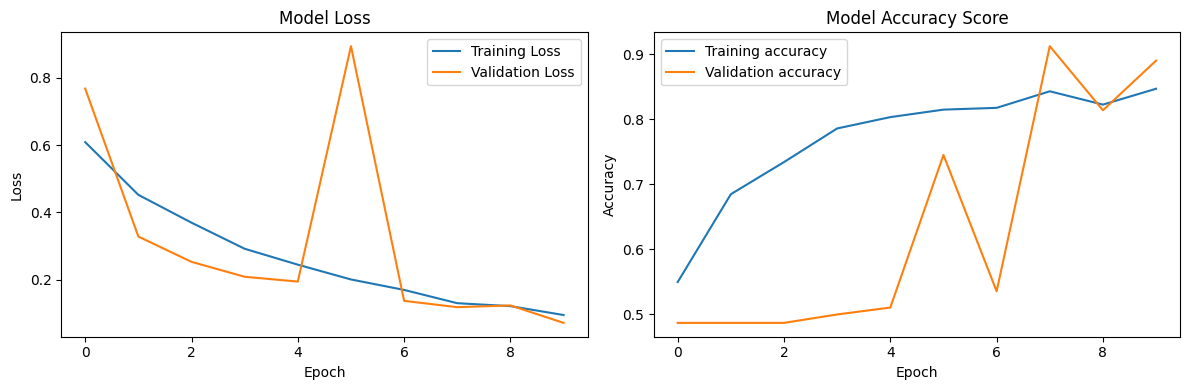

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_io_u_1'], label='Training accuracy')
plt.plot(history.history['val_mean_io_u_1'], label='Validation accuracy')
plt.title('Model Accuracy Score')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [169]:
model_path = "unet_trained_model.h5"  # HDF5 format
unet_model.save(model_path)

print(f"Model saved to {model_path}")


# unet_model = load_model("unet_trained_model.h5")
# print("Model loaded successfully!")


Model saved to unet_trained_model.h5


In [280]:
model_path = "D:/image_seg/unet_trained_model_1.h5"  # Use forward slashes or double backslashes
unet_model.save(model_path)

print(f"Model saved to {model_path}")


# unet_model = load_model("C:/Users/YourUsername/Documents/unet_trained_model.h5")
# print("Model loaded successfully!")


Model saved to D:/image_seg/unet_trained_model_1.h5


In [17]:
print(val_images.shape)
print(val_masks.shape)
print(val_images.min())
print(val_images.max())

(277, 128, 128, 1)
(277, 128, 128, 1)
0.02032470703125
1.0


In [18]:
# Evaluate and visualize results
sample_image = val_images[0].squeeze()
sample_mask = val_masks[0].squeeze()
print(sample_image.shape)
predicted_prob_map = unet_model.predict(np.expand_dims(sample_image, axis=(0, -1))).squeeze()


(128, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


In [19]:
print(np.unique(predicted_prob_map))
# predicted_prob_map = (predicted_prob_map - predicted_prob_map.min()) / (predicted_prob_map.max() - predicted_prob_map.min())
# print(np.unique(predicted_prob_map))

# threshold = 0.5 # Adjust based on dataset characteristics
# predicted_prob_map = (predicted_prob_map > threshold).astype(np.uint8)
# print(predicted_prob_map)




[0.02962099 0.03099362 0.03221644 ... 0.14352465 0.14382587 0.14461425]


In [99]:
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np

# # Normalize probability map
# scaler = MinMaxScaler()
# normalized_prob_map = scaler.fit_transform(predicted_prob_map.reshape(-1, 1)).reshape(predicted_prob_map.shape)

# # Remove very small values (avoid instability)
# normalized_prob_map[normalized_prob_map < 1e-5] = 0  

# # Convert to float64 for better precision
# predicted_prob_map = normalized_prob_map.astype(np.float64)
# print(predicted_prob_map)

# skfuzzy as fuzz

In [61]:
import numpy as np
import skfuzzy as fuzz
from sklearn.preprocessing import MinMaxScaler

def apply_fuzzy_cmeans(predicted_prob_map, n_clusters=3):
    # Normalize the input using MinMaxScaler
    pixels = predicted_prob_map.reshape(-1, 1)  # Flatten to (num_pixels, 1) , # Flatten to (16384, 1)
    scaler = MinMaxScaler()
    pixels = scaler.fit_transform(pixels).flatten()  # Convert to 1D array

    # Apply Fuzzy C-Means clustering
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        np.expand_dims(pixels, axis=0),  # Reshape to (1, num_pixels)
        c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
    )

    # Assign each pixel to the cluster with the highest membership value
    cluster_membership = np.argmax(u, axis=0)

    # Compute mean intensity of each cluster
    cluster_means = [np.mean(pixels[cluster_membership == i]) for i in range(n_clusters)]
    
    # Sort clusters by mean intensity (ensuring consistent labeling)
    sorted_clusters = np.argsort(cluster_means)  # Sorted indices from darkest to brightest
    label_map = {sorted_clusters[i]: i for i in range(n_clusters)}  # Create mapping
    
    # Apply the mapping to cluster labels
    segmented_image = np.vectorize(lambda x: label_map[x])(cluster_membership)

    # Reshape back to original image dimensions
    return segmented_image.reshape(predicted_prob_map.shape)


# custom fuzzy-c-means

In [58]:
def initialize_membership_matrix(n_samples, n_clusters):
    U = np.random.rand(n_samples, n_clusters)
    U = U / np.sum(U, axis=1, keepdims=True)
    return U

def update_centroids(data, U, m):
    um = U ** m
    centroids = np.dot(um.T, data) / np.sum(um.T, axis=1, keepdims=True)
    return centroids

def update_membership(data, centroids, m):
    n_samples, n_clusters = data.shape[0], centroids.shape[0]
    U = np.zeros((n_samples, n_clusters))
    for i in range(n_samples):
        for j in range(n_clusters):
            denom = sum((np.linalg.norm(data[i] - centroids[j]) /
                         np.linalg.norm(data[i] - centroids[k])) ** (2 / (m - 1))
                        for k in range(n_clusters))
            U[i, j] = 1 / denom
    return U

def fuzzy_c_means(data, n_clusters=3, m=2, max_iter=100, epsilon=1e-5):
    n_samples = data.shape[0]
    U = initialize_membership_matrix(n_samples, n_clusters)
    for _ in range(max_iter):
        centroids = update_centroids(data, U, m)
        U_new = update_membership(data, centroids, m)
        if np.linalg.norm(U_new - U) < epsilon:
            break
        U = U_new
    labels = np.argmax(U, axis=1)
    return labels, centroids, U

def og_fcm(predicted_prob_map, n_clusters=2):
    pixels = predicted_prob_map.reshape(-1, 1)
    labels, centroids, _ = fuzzy_c_means(pixels, n_clusters=n_clusters)

    # Sort clusters by centroid intensity
    sorted_indices = np.argsort(centroids.squeeze())
    
    # Remap labels to maintain consistency
    new_labels = np.zeros_like(labels)
    for new_label, old_label in enumerate(sorted_indices):
        new_labels[labels == old_label] = new_label

    refined_segmentation = new_labels.reshape(predicted_prob_map.shape)
    return refined_segmentation

# def apply_fcm(predicted_prob_map, n_clusters=3):
#     pixels = predicted_prob_map.reshape(-1, 1)
#     labels, _, _ = fuzzy_c_means(pixels, n_clusters=n_clusters)
#     refined_segmentation = labels.reshape(predicted_prob_map.shape)
#     return refined_segmentation

In [63]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter

def initialize_membership_matrix_new(n_samples, n_clusters):
    U = np.random.rand(n_samples, n_clusters)
    U = U / np.sum(U, axis=1, keepdims=True)
    return U

def update_centroids_new(data, U, m):
    um = U ** m
    centroids = np.dot(um.T, data) / np.sum(um.T, axis=1, keepdims=True)
    return centroids

def update_membership_new(data, centroids, m, attention):
    n_samples, n_clusters = data.shape[0], centroids.shape[0]
    U = np.zeros((n_samples, n_clusters))
    for i in range(n_samples):
        for j in range(n_clusters):
            denom = sum((np.linalg.norm(data[i] - centroids[j]) /
                         np.linalg.norm(data[i] - centroids[k])) ** (2 / (m - 1))
                        for k in range(n_clusters))
            U[i, j] = (1 / denom) * attention[i]  # Apply attention weight
    return U / np.sum(U, axis=1, keepdims=True)

def fuzzy_c_means_new(data, attention_map, n_clusters=3, m=2, max_iter=100, epsilon=1e-5):
    n_samples = data.shape[0]
    U = initialize_membership_matrix_new(n_samples, n_clusters)
    attention = attention_map.flatten() / (np.max(attention_map) + 1e-6)  # Normalize attention
    
    for _ in range(max_iter):
        centroids = update_centroids_new(data, U, m)
        U_new = update_membership_new(data, centroids, m, attention)
        if np.linalg.norm(U_new - U) < epsilon:
            break
        U = U_new
    
    labels = np.argmax(U, axis=1)
    return labels, centroids, U

def ag_fcm(predicted_prob_map, n_clusters=2):
    # Use U-Net output as attention map
    attention_map = gaussian_filter(predicted_prob_map, sigma=2)  # Smooth probability map

    pixels = predicted_prob_map.reshape(-1, 1)
    labels, centroids, _ = fuzzy_c_means_new(pixels, attention_map, n_clusters=n_clusters)

    # Ensure the tumor region (higher intensity) is always white
    tumor_cluster = np.argmax(centroids)  # Find the cluster with the highest intensity
    new_labels = (labels == tumor_cluster).astype(np.uint8)  # Assign 1 (white) to the tumor cluster

    refined_segmentation = new_labels.reshape(predicted_prob_map.shape)
    return refined_segmentation


# def ag_fcm(predicted_prob_map, n_clusters=2):
#     # Use U-Net output as attention map
#     attention_map = gaussian_filter(predicted_prob_map, sigma=2)  # Apply smoothing to enhance tumor regions
    
#     pixels = predicted_prob_map.reshape(-1, 1)
#     labels, centroids, _ = fuzzy_c_means(pixels, attention_map, n_clusters=n_clusters)

#     # Sort clusters by centroid intensity
#     sorted_indices = np.argsort(centroids.squeeze())
    
#     # Remap labels to maintain consistency
#     new_labels = np.zeros_like(labels)
#     for new_label, old_label in enumerate(sorted_indices):
#         new_labels[labels == old_label] = new_label
    
#     refined_segmentation = new_labels.reshape(predicted_prob_map.shape)
#     return refined_segmentation



In [60]:
refined_mask = og_fcm(predicted_prob_map, n_clusters=2)


print("Unique values:", np.unique(refined_mask))
print("Min:", refined_mask.min(), "Max:", refined_mask.max())


Unique values: [0 1]
Min: 0 Max: 1


In [64]:
attention_mask = ag_fcm(predicted_prob_map, n_clusters=2)

print("Unique values:", np.unique(attention_mask))
print("Min:", attention_mask.min(), "Max:", attention_mask.max())

Unique values: [0 1]
Min: 0 Max: 1


In [228]:
!pip install opencv-python


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Skipping sample 1 (Minimal tumor: 0.00%)
Skipping sample 2 (Minimal tumor: 0.00%)
Skipping sample 3 (Minimal tumor: 0.00%)
Skipping sample 4 (Minimal tumor: 0.00%)
Skipping sample 5 (Minimal tumor: 4.48%)
Skipping sample 6 (Minimal tumor: 0.00%)
Skipping sample 7 (Minimal tumor: 0.00%)
Sample 8: Image shape: (128, 128), Mask shape: (128, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


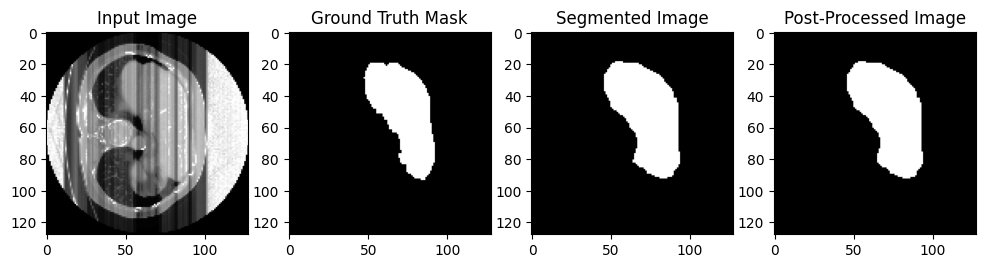

Processed Random Sample 8 Successfully!
Sample 9: Image shape: (128, 128), Mask shape: (128, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


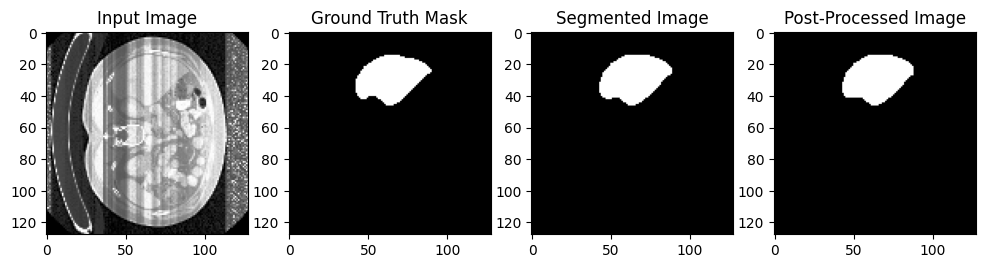

Processed Random Sample 9 Successfully!
Sample 10: Image shape: (128, 128), Mask shape: (128, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


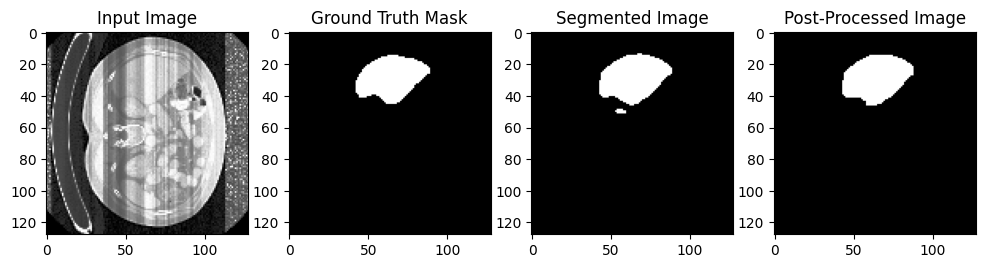

Processed Random Sample 10 Successfully!
Skipping sample 11 (Minimal tumor: 4.75%)
Skipping sample 12 (Minimal tumor: 0.00%)
Sample 13: Image shape: (128, 128), Mask shape: (128, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


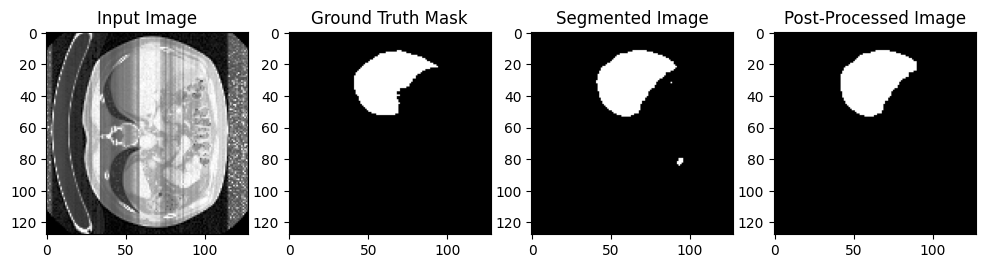

Processed Random Sample 13 Successfully!
Skipping sample 14 (Minimal tumor: 0.00%)
Sample 15: Image shape: (128, 128), Mask shape: (128, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


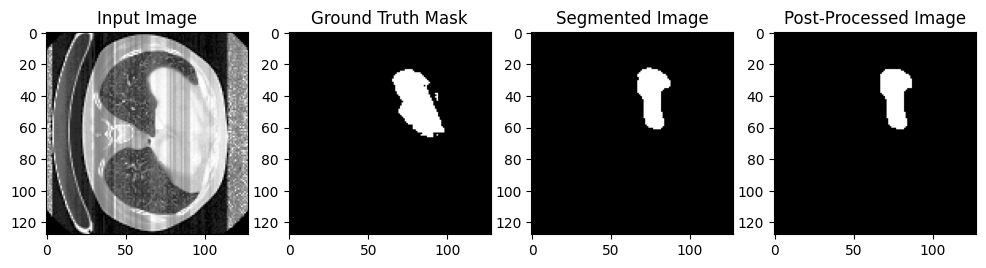

Processed Random Sample 15 Successfully!


In [66]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# Define a kernel for morphological operations
kernel = np.ones((5, 5), np.uint8)

# # Number of samples to process
# num_samples = 10

# # Randomly shuffle indices
# random_indices = random.sample(range(len(val_images)), num_samples)


# # Loop through the randomly selected samples
# for i, idx in enumerate(random_indices):
#     # Get the randomly selected sample image and mask
#     sample_image = val_images[idx].squeeze()  # Remove channel dimension if necessary
#     sample_mask = val_masks[idx].squeeze()   # Ground truth mask

# Number of samples you want to evaluate
num_samples = 15# Adjust this value as needed

# Loop through the desired number of samples
for i in range(num_samples):
    # Get the i-th sample image and mask from the validation set
    sample_image = val_images[i].squeeze()  # Remove the channel dimension
    sample_mask = val_masks[i].squeeze()   # Ground truth mask

    # Set a threshold for minimum tumor presence
    tumor_threshold = 0.05  # 5% of the mask

    # Calculate tumor presence
    tumor_ratio = np.sum(sample_mask > 0.2) / sample_mask.size  # Ratio of tumor pixels

    # Skip if the tumor area is too small
    if tumor_ratio < tumor_threshold:
        print(f"Skipping sample {i+1} (Minimal tumor: {tumor_ratio:.2%})")
        continue

    # Print shape to confirm input dimensions (optional)
    print(f"Sample {i+1}: Image shape: {sample_image.shape}, Mask shape: {sample_mask.shape}")


    # Predict the probability map using the trained model
    predicted_prob_map = unet_model.predict(np.expand_dims(sample_image, axis=(0, -1))).squeeze()

    # # Apply Fuzzy C-Means clustering for segmentation
    # seg_image = apply_fuzzy_cmeans(predicted_prob_map, n_clusters=2)

    # # Convert segmented image to uint8 for OpenCV
    # seg_image = seg_image.astype(np.uint8)


    refined_mask = og_fcm(predicted_prob_map, n_clusters=2)
    refined_mask = refined_mask.astype(np.uint8)

    # dilated_map = cv2.dilate(seg_image, kernel, iterations=1)

    # Apply morphological closing instead of dilation
    close_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel)


    # Apply morphological opening (removes small false positives)
    open_mask = cv2.morphologyEx(close_mask, cv2.MORPH_OPEN, kernel)

 

    # Visualize the results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(sample_image, cmap="gray")
    plt.title("Input Image")
    
    plt.subplot(1, 4, 2)
    plt.imshow(sample_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    plt.subplot(1, 4, 3)
    plt.imshow(refined_mask, cmap="gray")
    plt.title("Segmented Image")
    
    plt.subplot(1, 4, 4)
    plt.imshow(open_mask, cmap="gray")
    plt.title("Post-Processed Image")
    
    plt.show()

    print(f"Processed Random Sample {i+1} Successfully!")


Skipping sample 230 (Minimal tumor: 0.00%)
Skipping sample 159 (Minimal tumor: 0.00%)
Skipping sample 133 (Minimal tumor: 0.00%)
Skipping sample 28 (Minimal tumor: 0.00%)
Skipping sample 195 (Minimal tumor: 0.00%)
Skipping sample 206 (Minimal tumor: 0.00%)
Skipping sample 189 (Minimal tumor: 0.00%)
Skipping sample 135 (Minimal tumor: 0.00%)
Sample 78: Image shape: (128, 128), Mask shape: (128, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


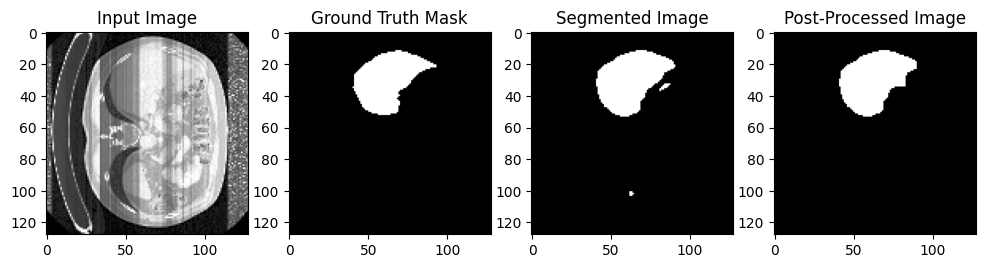

Processed Random Sample 78 Successfully!
Skipping sample 184 (Minimal tumor: 0.00%)


In [47]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# Define a kernel for morphological operations
kernel = np.ones((5, 5), np.uint8)

# Number of samples to process
num_samples = 10

# Randomly shuffle indices
random_indices = random.sample(range(len(val_images)), num_samples)

# Loop through the randomly selected samples
for i, idx in enumerate(random_indices):
    # Get the randomly selected sample image and mask
    sample_image = val_images[idx].squeeze()  # Remove channel dimension if necessary
    sample_mask = val_masks[idx].squeeze()   # Ground truth mask

# # Number of samples you want to evaluate
# num_samples = 15# Adjust this value as needed

# # Loop through the desired number of samples
# for i in range(num_samples):
#     # Get the i-th sample image and mask from the validation set
#     sample_image = val_images[i].squeeze()  # Remove the channel dimension
#     sample_mask = val_masks[i].squeeze()   # Ground truth mask

    # Set a threshold for minimum tumor presence
    tumor_threshold = 0.02 # 5% of the mask

    # Calculate tumor presence
    tumor_ratio = np.sum(sample_mask > 0.2) / sample_mask.size  # Ratio of tumor pixels

    # Skip if the tumor area is too small
    if tumor_ratio < tumor_threshold:
        print(f"Skipping sample {idx+1} (Minimal tumor: {tumor_ratio:.2%})")
        continue

    # Print shape to confirm input dimensions (optional)
    print(f"Sample {idx+1}: Image shape: {sample_image.shape}, Mask shape: {sample_mask.shape}")


    # Predict the probability map using the trained model
    predicted_prob_map = unet_model.predict(np.expand_dims(sample_image, axis=(0, -1))).squeeze()

    attention_mask = ag_fcm(predicted_prob_map, n_clusters=2)
    attention_mask = attention_mask.astype(np.uint8)

    # dilated_map = cv2.dilate(seg_image, kernel, iterations=1)

    # Apply morphological closing instead of dilation
    close_mask = cv2.morphologyEx(attention_mask, cv2.MORPH_CLOSE, kernel)


    # Apply morphological opening (removes small false positives)
    open_mask = cv2.morphologyEx(close_mask, cv2.MORPH_OPEN, kernel)

 

    # Visualize the results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(sample_image, cmap="gray")
    plt.title("Input Image")
    
    plt.subplot(1, 4, 2)
    plt.imshow(sample_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    plt.subplot(1, 4, 3)
    plt.imshow(attention_mask, cmap="gray")
    plt.title("Segmented Image")
    
    plt.subplot(1, 4, 4)
    plt.imshow(open_mask, cmap="gray")
    plt.title("Post-Processed Image")
    
    plt.show()

    print(f"Processed Random Sample {idx+1} Successfully!")


In [67]:
import numpy as np
import cv2

# Function to compute Dice Coefficient
def dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)
    return (2. * intersection) / sum_masks if sum_masks != 0 else 1.0  # Avoid division by zero

# Lists to store the masks and Dice scores
stored_sample_masks = []
stored_refined_masks = []
dice_scores = []

for i in range(num_samples):
    # Get the randomly selected sample image and mask
    sample_image = val_images[i].squeeze()  # Remove channel dimension if necessary
    sample_mask = val_masks[i].squeeze()   # Ground truth mask

    # Set a threshold for minimum tumor presence
    tumor_threshold = 0.05  # 5% of the mask

    # Calculate tumor presence
    tumor_ratio = np.sum(sample_mask > 0.2) / sample_mask.size  # Ratio of tumor pixels

    # Skip if the tumor area is too small
    if tumor_ratio < tumor_threshold:
        print(f"Skipping sample {i+1} (Minimal tumor: {tumor_ratio:.2%})")
        continue

    # Predict the probability map using the trained model
    predicted_prob_map = unet_model.predict(np.expand_dims(sample_image, axis=(0, -1))).squeeze()

    # Generate attention mask using AG-FCM
    refined_mask = og_fcm(predicted_prob_map, n_clusters=2)

    # # Convert masks to binary (thresholding)
    # binary_sample_mask = (sample_mask > 0.2).astype(np.uint8)  # Ground truth binary mask
    # binary_attention_mask = (attention_mask > 0.5).astype(np.uint8)  # AG-FCM output binary mask

    # Compute Dice Coefficient
    dice_score = dice_coefficient(sample_mask, refined_mask)
    dice_scores.append(dice_score)

    print(f"Sample {i+1}: Dice Coefficient = {dice_score:.4f}")

    # Store the masks
    stored_sample_masks.append(sample_mask)
    stored_refined_masks.append(refined_mask)

    # # Optionally, save them as image files
    # cv2.imwrite(f"sample_mask_{idx}.png", (sample_mask * 255).astype(np.uint8))
    # cv2.imwrite(f"attention_mask_{idx}.png", (attention_mask * 255).astype(np.uint8))

# Compute the average Dice coefficient
average_dice = np.mean(dice_scores) if dice_scores else 0
print(f"Average Dice Coefficient: {average_dice:.4f}")


Skipping sample 1 (Minimal tumor: 0.00%)
Skipping sample 2 (Minimal tumor: 0.00%)
Skipping sample 3 (Minimal tumor: 0.00%)
Skipping sample 4 (Minimal tumor: 0.00%)
Skipping sample 5 (Minimal tumor: 4.48%)
Skipping sample 6 (Minimal tumor: 0.00%)
Skipping sample 7 (Minimal tumor: 0.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Sample 8: Dice Coefficient = 0.9263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Sample 9: Dice Coefficient = 0.9690
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Sample 10: Dice Coefficient = 0.9577
Skipping sample 11 (Minimal tumor: 4.75%)
Skipping sample 12 (Minimal tumor: 0.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Sample 13: Dice Coefficient = 0.9426
Skipping sample 14 (Minimal tumor: 0.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Sample 15: Dice Coefficient = 0.7258
Average Dice Coefficient: 0.9043


In [ ]:
import numpy as np
import cv2

# Function to compute Dice Coefficient
def dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)
    return (2. * intersection) / sum_masks if sum_masks != 0 else 1.0  # Avoid division by zero

# Lists to store the masks and Dice scores
stored_sample_mask = []
stored_attention_masks = []
dice_scores = []

for i, idx in enumerate(random_indices):
    # Get the randomly selected sample image and mask
    sample_image = val_images[idx].squeeze()  # Remove channel dimension if necessary
    sample_mask = val_masks[idx].squeeze()   # Ground truth mask

    # Set a threshold for minimum tumor presence
    tumor_threshold = 0.05  # 5% of the mask

    # Calculate tumor presence
    tumor_ratio = np.sum(sample_mask > 0.2) / sample_mask.size  # Ratio of tumor pixels

    # Skip if the tumor area is too small
    if tumor_ratio < tumor_threshold:
        print(f"Skipping sample {idx+1} (Minimal tumor: {tumor_ratio:.2%})")
        continue

    # Predict the probability map using the trained model
    predicted_prob_map = unet_model.predict(np.expand_dims(sample_image, axis=(0, -1))).squeeze()

    # Generate attention mask using AG-FCM
    attention_mask = ag_fcm(predicted_prob_map, n_clusters=2)

    # # Convert masks to binary (thresholding)
    # binary_sample_mask = (sample_mask > 0.2).astype(np.uint8)  # Ground truth binary mask
    # binary_attention_mask = (attention_mask > 0.5).astype(np.uint8)  # AG-FCM output binary mask

    # Compute Dice Coefficient
    dice_score = dice_coefficient(sample_mask, attention_mask)
    dice_scores.append(dice_score)

    print(f"Sample {idx+1}: Dice Coefficient = {dice_score:.4f}")

    # Store the masks
    stored_sample_mask.append(sample_mask)
    stored_attention_masks.append(attention_mask)

    # # Optionally, save them as image files
    # cv2.imwrite(f"sample_mask_{idx}.png", (sample_mask * 255).astype(np.uint8))
    # cv2.imwrite(f"attention_mask_{idx}.png", (attention_mask * 255).astype(np.uint8))

# Compute the average Dice coefficient
average_dice = np.mean(dice_scores) if dice_scores else 0
print(f"Average Dice Coefficient: {average_dice:.4f}")


Skipping sample 230 (Minimal tumor: 0.00%)
Skipping sample 159 (Minimal tumor: 0.00%)
Skipping sample 133 (Minimal tumor: 0.00%)
Skipping sample 28 (Minimal tumor: 0.00%)
Skipping sample 195 (Minimal tumor: 0.00%)
Skipping sample 206 (Minimal tumor: 0.00%)
Skipping sample 189 (Minimal tumor: 0.00%)
Skipping sample 135 (Minimal tumor: 0.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Sample 78: Dice Coefficient = 0.9489
Skipping sample 184 (Minimal tumor: 0.00%)
Average Dice Coefficient: 0.9489


In [70]:
import numpy as np

def dice_coefficient(mask1, mask2):
    mask1 = np.array(mask1, dtype=np.uint8)
    mask2 = np.array(mask2, dtype=np.uint8)

    intersection = np.sum(mask1 * mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)
    
    return (2. * intersection) / sum_masks if sum_masks != 0 else 1.0

def iou(mask1, mask2):
    mask1 = np.array(mask1, dtype=np.uint8)
    mask2 = np.array(mask2, dtype=np.uint8)

    intersection = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2) - intersection
    
    return intersection / union if union != 0 else 1.0

def accuracy(mask1, mask2):
    mask1 = np.array(mask1, dtype=np.uint8)
    mask2 = np.array(mask2, dtype=np.uint8)

    correct = np.sum(mask1 == mask2)
    total = mask1.size
    
    return correct / total

# Compute metrics
dice_score_og = dice_coefficient(stored_sample_masks, stored_refined_masks)
iou_score_og = iou(stored_sample_masks, stored_refined_masks)
accuracy_og = accuracy(stored_sample_masks, stored_refined_masks)

dice_score = dice_coefficient(stored_sample_mask, stored_attention_masks)
iou_score = iou(stored_sample_mask, stored_attention_masks)
accuracy_score = accuracy(stored_sample_mask, stored_attention_masks)

# Print results
print(f"Dice Coefficient_og: {dice_score_og:.4f}, IoU_og: {iou_score_og:.4f}, Accuracy_og: {accuracy_og:.4f}")
print(f"Dice Coefficient: {dice_score:.4f}, IoU: {iou_score:.4f}, Accuracy: {accuracy_score:.4f}")


Dice Coefficient_og: 0.9198, IoU_og: 0.8515, Accuracy_og: 0.9880
Dice Coefficient: 0.9489, IoU: 0.9028, Accuracy: 0.9921


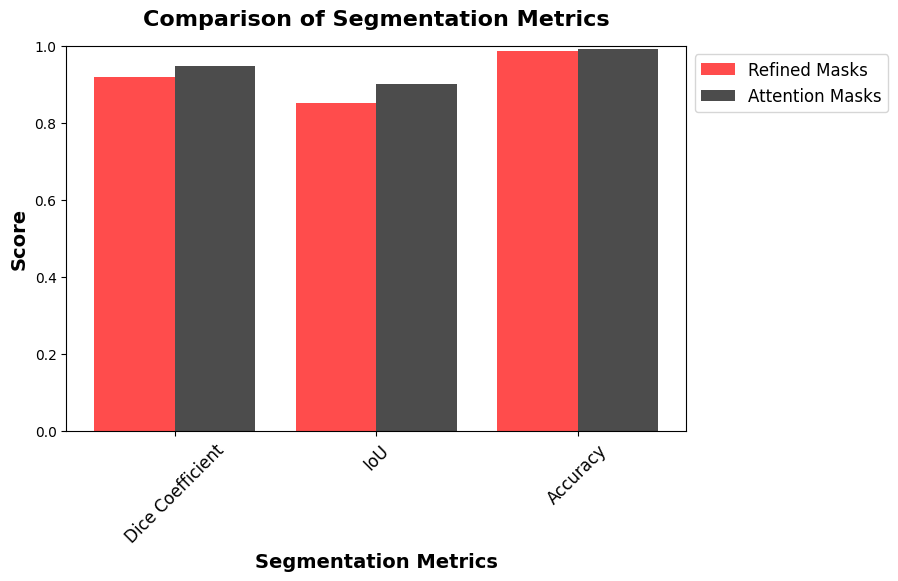

In [72]:
import matplotlib.pyplot as plt

# Metrics
labels = ["Dice Coefficient", "IoU", "Accuracy"]
original_scores = [dice_score_og, iou_score_og, accuracy_og]
attention_scores = [dice_score, iou_score, accuracy_score]

x = range(len(labels))

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(x, original_scores, width=0.4, label="Refined Masks", alpha=0.7, color='red')
plt.bar([i + 0.4 for i in x], attention_scores, width=0.4, label="Attention Masks", alpha=0.7, color='black')

# Labels
plt.xlabel("Segmentation Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontsize=14, fontweight='bold')
plt.title("Comparison of Segmentation Metrics", fontsize=16, fontweight='bold', pad=15)
plt.xticks([i + 0.2 for i in x], labels, rotation=45, fontsize=12)
plt.ylim(0, 1)
# plt.legend(fontsize=12, loc="upper left")
plt.legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))


# Show plot
plt.show()
